In [1]:
import os
import numpy as np
import scipy.io as scio
import matplotlib.pyplot as plt
from random import shuffle
import seaborn as sns
import math
from scipy.stats import f_oneway
from scipy.signal import resample
from tqdm import tqdm 
import matplotlib.image as mpimg
import pandas as pd
from pynwb import NWBFile, NWBHDF5IO
from matplotlib.lines import Line2D

In [2]:
path_to_save_Data = os.getcwd().rstrip('/code')
print(path_to_save_Data)

/Users/zhanghaobo/Desktop/ASCCD_dataset_BIDS


# Get Vowel begin time

In [3]:
def get_timelocked_activity(times, hg, back, forward, hz=400):
    #times = np.array(times)
    '''
    get_timelocked_activity(np.array([2]), a['bands'][0], back=0.5, forward=0.5)
    '''
    if hz:
        times = (times*hz).astype(int)
        back = int(back*hz)
        forward = int(forward*hz)
    times = times[times - back > 0]
    times = times[times + forward < hg.shape[-1]]
    if hg.ndim == 3:
        Y_mat = np.zeros((len(times), hg.shape[0], hg.shape[1], int(back + forward)), dtype=float)
        for i, index in enumerate(times):
            Y_mat[i, :, :, :] = hg[:,:, int(index-back):int(index+forward)]
    elif hg.ndim == 2:
        Y_mat = np.zeros((len(times), hg.shape[0], int(back + forward)), dtype=float)
        for i, index in enumerate(times):
            Y_mat[i, :, :] = hg[:, int(index-back):int(index+forward)]
    else:
        Y_mat = np.zeros((len(times), int(back + forward)), dtype=float)
        for i, index in enumerate(times):
            Y_mat[i,  :] = hg[int(index-back):int(index+forward)]
            
    return Y_mat, back, forward

In [4]:
def get_ecogdict(sub, session, back=0.2, forward=0.6, hz=400):
    
    with NWBHDF5IO(path_to_save_Data+f'/{sub}/ieeg/{sub}_task-audio_run-{session}_ieeg.nwb', 'r') as io:
        nwbfile = io.read()
        iEEG_ts = nwbfile.acquisition['iEEG']
        iEEG_data = iEEG_ts.data[:]
        ecog = iEEG_data.T

    ecog = (ecog - np.mean(ecog, axis=-1, keepdims=True)) / np.std(ecog, axis=-1, keepdims=True)
    ecogdict = {}
    asccd_file = np.load(path_to_save_Data+f'/derivatives/Annotations/{sub}/{sub}_task-audio_run-{session}_pinyin.npy', allow_pickle=True).item()['pinyin_list']
    pinyin_offset_time = np.load(path_to_save_Data+f'/derivatives/Annotations/{sub}/{sub}_task-audio_run-{session}_pinyin.npy', allow_pickle=True).item()['offset_list']

    # 构建 indices_dict
    indices_dict = {
        d: np.where(np.char.endswith(asccd_file, str(d)))[0]  # 找以 d 结尾的下标
        for d in range(5)
    }
    matching_file_in_syl = np.load(path_to_save_Data+f'/derivatives/Annotations/{sub}/{sub}_task-audio_run-{session}_syllable.npy', allow_pickle=True).item()['offset_list']
    vowel_onset_time = np.load(path_to_save_Data+f'/derivatives/Annotations/{sub}/{sub}_task-audio_run-{session}_syllable.npy', allow_pickle=True).item()['onset_list']
    for key in indices_dict.keys():
        offset_time = pinyin_offset_time[indices_dict[key]]
        # 建立值到索引的映射
        index_map = {v: i for i, v in enumerate(matching_file_in_syl)}
        # 只保留那些在 index_map 中能找到的位置
        positions = [index_map[v] for v in offset_time if v in index_map]
        onset_time = vowel_onset_time[positions]
        # print(onset_time)
        ecogdict[key] = get_timelocked_activity(onset_time, ecog, back, forward, hz=hz)[0].transpose(1, 2, 0)
        # print(ecogdict[key].shape)
    
    return ecogdict

In [5]:
def get_ecogdict2(sub, session, back=0.2, forward=0.6, hz=400):

    with NWBHDF5IO(path_to_save_Data+f'/{sub}/ieeg/{sub}_task-audio_run-{session}_ieeg.nwb', 'r') as io:
        nwbfile = io.read()
        iEEG_ts = nwbfile.acquisition['iEEG']
        iEEG_data = iEEG_ts.data[:]
        ecog = iEEG_data.T

    ecog = (ecog - np.mean(ecog, axis=-1, keepdims=True)) / np.std(ecog, axis=-1, keepdims=True)
    ecogdict = {}
    silence_list = np.load(path_to_save_Data+f'/derivatives/Annotations/{sub}/{sub}_task-audio_run-{session}_silence.npy', allow_pickle=True).item()
    indices = np.where((silence_list['offset_list']-silence_list['onset_list']) > 0.2)[0]
    indices = indices[:-1]
    ecogdict[0] = get_timelocked_activity(silence_list['offset_list'][indices], ecog, back, forward, hz=hz)[0].transpose(1, 2, 0)
    # print(ecogdict, ecogdict[0].shape)
    return ecogdict

# Define which Patient to process

In [6]:
sub = 'sub-01'
blocklist_dict = {
    'sub-01': ['01', '02', '03', '04', '05', '06'],
    'sub-02': ['01', '02', '03', '04', '05', '06'],
    'sub-03': ['01', '02', '03', '04'],
    'sub-04': ['01', '02', '03', '04']
}
blocklist = blocklist_dict[sub]

In [7]:
if sub == 'sub-01' or sub == 'sub-02':
    ecogdict1_tone = get_ecogdict(sub=sub, session=blocklist[0])
    ecogdict2_tone = get_ecogdict(sub=sub, session=blocklist[1])
    ecogdict3_tone = get_ecogdict(sub=sub, session=blocklist[2])
    ecogdict4_tone = get_ecogdict(sub=sub, session=blocklist[3])
    ecogdict5_tone = get_ecogdict(sub=sub, session=blocklist[4])
    ecogdict6_tone = get_ecogdict(sub=sub, session=blocklist[5])
    for k in ecogdict1_tone:
        print(k,
            ecogdict1_tone[k].shape,
            ecogdict2_tone[k].shape,
            ecogdict3_tone[k].shape,
            ecogdict4_tone[k].shape,
            ecogdict5_tone[k].shape,
            ecogdict6_tone[k].shape)
    ecogdict_tone = {k: np.concatenate((ecogdict1_tone[k], ecogdict2_tone[k], ecogdict3_tone[k],
                                        ecogdict4_tone[k], ecogdict5_tone[k], ecogdict6_tone[k]), axis=-1)   # axis=-1 或 2 都行
                for k in ecogdict1_tone}
    ecogdict1_speech = get_ecogdict2(sub=sub, session=blocklist[0])
    ecogdict2_speech = get_ecogdict2(sub=sub, session=blocklist[1])
    ecogdict3_speech = get_ecogdict2(sub=sub, session=blocklist[2])
    ecogdict4_speech = get_ecogdict2(sub=sub, session=blocklist[3])
    ecogdict5_speech = get_ecogdict2(sub=sub, session=blocklist[4])
    ecogdict6_speech = get_ecogdict2(sub=sub, session=blocklist[5])
    for k in ecogdict1_speech:
        print(k,
            ecogdict1_speech[k].shape,
            ecogdict2_speech[k].shape,
            ecogdict3_speech[k].shape,
            ecogdict4_speech[k].shape,
            ecogdict5_speech[k].shape,
            ecogdict6_speech[k].shape)
    ecogdict_speech = {k: np.concatenate((ecogdict1_speech[k], ecogdict2_speech[k], ecogdict3_speech[k],
                                        ecogdict4_speech[k], ecogdict5_speech[k], ecogdict6_speech[k]), axis=-1)   # axis=-1 或 2 都行
                for k in ecogdict1_speech}
elif sub == 'sub-03' or sub == 'sub-04':
    ecogdict1_tone = get_ecogdict(sub=sub, session=blocklist[0])
    ecogdict2_tone = get_ecogdict(sub=sub, session=blocklist[1])
    ecogdict3_tone = get_ecogdict(sub=sub, session=blocklist[2])
    ecogdict4_tone = get_ecogdict(sub=sub, session=blocklist[3])
    for k in ecogdict1_tone:
        print(k,
            ecogdict1_tone[k].shape,
            ecogdict2_tone[k].shape,
            ecogdict3_tone[k].shape,
            ecogdict4_tone[k].shape)
    ecogdict_tone = {k: np.concatenate((ecogdict1_tone[k], ecogdict2_tone[k], ecogdict3_tone[k],
                                        ecogdict4_tone[k]), axis=-1)   # axis=-1 或 2 都行
                for k in ecogdict1_tone}
    ecogdict1_speech = get_ecogdict2(sub=sub, session=blocklist[0])
    ecogdict2_speech = get_ecogdict2(sub=sub, session=blocklist[1])
    ecogdict3_speech = get_ecogdict2(sub=sub, session=blocklist[2])
    ecogdict4_speech = get_ecogdict2(sub=sub, session=blocklist[3])
    for k in ecogdict1_speech:
        print(k,
            ecogdict1_speech[k].shape,
            ecogdict2_speech[k].shape,
            ecogdict3_speech[k].shape,
            ecogdict4_speech[k].shape)
    ecogdict_speech = {k: np.concatenate((ecogdict1_speech[k], ecogdict2_speech[k], ecogdict3_speech[k],
                                        ecogdict4_speech[k]), axis=-1)   # axis=-1 或 2 都行
                for k in ecogdict1_speech}

0 (128, 320, 57) (128, 320, 84) (128, 320, 78) (128, 320, 75) (128, 320, 85) (128, 320, 87)
1 (128, 320, 110) (128, 320, 144) (128, 320, 123) (128, 320, 166) (128, 320, 148) (128, 320, 147)
2 (128, 320, 125) (128, 320, 145) (128, 320, 135) (128, 320, 216) (128, 320, 193) (128, 320, 174)
3 (128, 320, 106) (128, 320, 151) (128, 320, 103) (128, 320, 140) (128, 320, 138) (128, 320, 137)
4 (128, 320, 204) (128, 320, 269) (128, 320, 239) (128, 320, 334) (128, 320, 272) (128, 320, 283)
0 (128, 320, 76) (128, 320, 121) (128, 320, 82) (128, 320, 114) (128, 320, 95) (128, 320, 117)


In [8]:
def get_timelocked_activity2(times, hg, back, forward, hz=False):
    #times = np.array(times)
    if hz:
        times = (times*hz/1000).astype(int)
        back = int(back*hz/1000)
        forward = int(forward*hz/1000)
    times = times[times - back > 0]
    if hg.ndim != 1:
        times = times[times + forward < hg.shape[1]]
        Y_mat = np.zeros(( len(hg), int(back + forward),len(times)), dtype=float)
        for i, index in enumerate(times):
            Y_mat[:, :, i] = hg[:, int(index-back):int(index+forward)]
    else:
        times = times[times + forward < hg.shape[0]]
        Y_mat = np.zeros((int(back + forward),len(times)), dtype=float)
        for i, index in enumerate(times):
            Y_mat[:,  i] = hg[int(index-back):int(index+forward)]
    return Y_mat,back,forward

#ecogmat,_,_ = get_timelocked_activity2(onsets[label_list==label], ecogOutput, 0.2, 0.8, hz=3052)
def sort_elecs_by_duration(sig_duration, is_small2large, *args):
    # Convert sig_duration to a NumPy array
    sig_duration = np.array(sig_duration)
    # Get the sorted indices based on sig_duration
    sorted_indices = np.argsort(sig_duration) if is_small2large else np.argsort(sig_duration)[::-1]
    # Rearrange all input lists based on the sorted indices
    sorted_sig_duration = list(sig_duration[sorted_indices])  # Convert to a list
    sorted_args = [sorted_sig_duration,]
    sorted_args.extend([[arg[i] for i in sorted_indices] for arg in args])
    #print(sorted_args)
    return tuple(sorted_args)

def nansem(a, axis=1):
    return np.nanstd(a, axis=1) / np.sqrt(a.shape[axis])
def find_continus(aa):
    l1 = []
    total = []
    for x in sorted(set(aa)):
        l1.append(x)
        if x + 1 not in aa:
            total.append(l1)
            l1 = []
    return total
def get_max_len(aa):
    max_len = 0
    for a in aa:
        if len(a) > max_len:
            max_len = len(a)
    return max_len

def plot_filled_sem(a, xvals, ax=None, color=None, ylim=None):
    if ax is None:
        fig, ax = plt.subplots()
    mean = np.nanmean(a, axis=1)
    sem = nansem(a, axis=1)
    #print(mean,sem)
    ax.axvline(0, color='gray', linewidth=0.5)
    ax.axhline(0, color='gray', linewidth=0.5)

    if color is not None:
        h = ax.fill_between(xvals, mean - sem, mean + sem, alpha=0.6, color=color)
    else:
        h = ax.fill_between(xvals, mean - sem, mean + sem, alpha=0.6, )

    if ylim is not None:
        ax.set(ylim=ylim)
    ax.set(xlim=(xvals[0], xvals[-1]))
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    return ax

In [9]:
def permutation_generate(ecogReading, Tfull, Trange, Tthres, check_list,
                        n_std=3, perm_num=1000, save_all_elecs=False):
    
    wholeLen = ecogReading[check_list[0]].shape[1]
    hz = wholeLen*1000/(Tfull[0]+Tfull[1])
    onset = Tfull[0]*hz/1000
    keyLen = len(ecogReading[check_list[0]][0,int(onset-Trange[0]*hz/1000):int(onset+Trange[1]*hz/1000)])
    #xvals = np.linspace(-Tfull[0], Tfull[1], wholeLen) 
    kxvals = np.linspace(-Trange[0], Trange[1], keyLen) 
    
    task_nums = len(check_list)
    hsblock = []
    for check in check_list:
        hsblock.append(ecogReading[check][:,int(onset-Trange[0]*hz/1000):int(onset+Trange[1]*hz/1000)])
    z = np.concatenate(hsblock,axis=2)
    print('elecs|duration|total_trials:',z.shape)
    trial_nums = z.shape[2]
    p = np.concatenate(z.transpose(2,0,1),axis=1)
    perm_mean = []
    
    for perm in tqdm(range(perm_num)):
        hg = p
        t_min = 0
        t_max = hg.shape[-1]*1000/hz - Trange[1]
        #平均到每一个task的trial数目，才可以做检验，不然平均太多了
        onsets_perm = np.random.uniform(t_min,t_max,int(trial_nums/task_nums))
        Y_mats_perm,_,_ = get_timelocked_activity2(onsets_perm, hg, hz=hz,back=Trange[0], forward=Trange[1])
        #print()
        Y_perm_mean = np.mean(Y_mats_perm, axis=-1)
        perm_mean.append(Y_perm_mean)
        
    perm_mean_one = np.array(perm_mean)
    #print('#',perm_mean_one.shape) # (1000, 256, 80) 次数 电极数 滑窗的个数（试次决定的）
    mean = np.mean(perm_mean_one,axis=0)
    std = np.std(perm_mean_one,axis=0) #(256,80)
    resp_elecs= []
    resp_duration = []
    resp_kxvals = []
    all_kxvals = []
    for pidx in range(len(ecogReading[check_list[0]])):
        #print(mean.shape,np.nanmean(z,axis = -1).shape)
        seg_index = np.where(np.nanmean(z,axis = -1)[pidx] - mean[pidx] - n_std * std[pidx] > 0)[0]
        if save_all_elecs:
            all_kxvals.append(kxvals[seg_index])
        max_len = get_max_len(find_continus(seg_index))*1000/hz
        print(str(int(max_len)),end='|')
        if max_len > Tthres:
            resp_elecs.append(pidx)
            resp_duration.append(max_len)
            resp_kxvals.append(kxvals[seg_index])
            
    sorted_resp_duration, sorted_resp_elecs, sorted_resp_kxvals = sort_elecs_by_duration(resp_duration, False, 
                                                                                         resp_elecs, resp_kxvals)
    if save_all_elecs:
        print('save_all_elecs is ON!')
        return sorted_resp_elecs, sorted_resp_duration, all_kxvals
    else:
        return sorted_resp_elecs, sorted_resp_duration, sorted_resp_kxvals

In [10]:
def anova_generate(ecogReading, Tfull, Trange, Tthres, check_list, 
                   continus = True, save_all_elecs = False):
    
    sig_elecs = []
    sig_duration = []
    sig_kxvals = []
    sig_pvals = []
    all_pvals = []
    all_kxvals = []
    
    threshold = 0.05 / (240*6) # Bonferroni

    wholeLen = ecogReading[check_list[0]].shape[1]
    hz = wholeLen*1000/(Tfull[0]+Tfull[1])
    onset = Tfull[0]*hz/1000
    keyLen = len(ecogReading[check_list[0]][0,int(onset-Trange[0]*hz/1000):int(onset+Trange[1]*hz/1000)])
    kxvals = np.linspace(-Trange[0], Trange[1], keyLen) 
    
    for pidx in range(len(ecogReading[check_list[0]])):
        sig_test = []
        for k in range(len(check_list)):
            a = ecogReading[check_list[k]][pidx,int(onset-Trange[0]*hz/1000):int(onset+Trange[1]*hz/1000)]
            '''
            if mean_erp:
                plot_filled_sem_2(a, kxvals, ax=axs[i, j], color=color_list[k])
            else:
                plot_filled_sem(a, kxvals, ax=axs[i, j], color=color_list[k])
            '''
            a = a[:, ~np.isnan(a).any(axis=0)].T
            sig_test.append(a)
            
        df=pd.DataFrame(data={'kxval':kxvals,'oneway':(f_oneway(*sig_test).pvalue)})
        df_sig = df[df['oneway']<=threshold]
        #df_non = df[df['oneway']>threshold]

        if save_all_elecs:
            all_pvals.append(np.array(df_sig['oneway']))
            all_kxvals.append(np.array(df_sig['kxval']))
            #print(np.array(df_sig['oneway']))
            #print(np.array(df_sig['kxval']))

        if continus:
            sig_idx  = df_sig.index.to_numpy()          # 或 np.where(df['oneway']<=threshold)[0]
            max_len  = get_max_len(find_continus(sig_idx)) * 1000 / hz
            print(int(max_len), end='|')
            if max_len > Tthres:
                print(pidx)
                sig_elecs.append(pidx)
                sig_duration.append(max_len)
                sig_pvals.append(np.array(df_sig['oneway']))
                sig_kxvals.append(np.array(df_sig['kxval']))

        else:
            max_len = len(df_sig['oneway'])*1000/hz
            print(int(max_len), end='|')
            if max_len > Tthres:
                sig_elecs.append(pidx)
                sig_duration.append(max_len)
                sig_pvals.append(np.array(df_sig['oneway']))
                sig_kxvals.append(np.array(df_sig['kxval']))
                
    #print(len(sig_elecs), len(sig_kxvals), len(sig_pvals))
    sorted_sig_duration, sorted_sig_elecs, sorted_sig_kxvals, sorted_sig_pvals = sort_elecs_by_duration(sig_duration, False, #
                                                                                         sig_elecs, sig_kxvals, sig_pvals)
    if save_all_elecs:
        print('save_all_elecs is ON!')
        return sorted_sig_elecs, sorted_sig_duration, all_kxvals, all_pvals
    else:
        return sorted_sig_elecs, sorted_sig_duration, sorted_sig_kxvals, sorted_sig_pvals

In [11]:
def single_elecs_ERP_figure(pidx, ecogReading, Tfull, Trange, label_name, check_list, color_list, name = None,
                            sig_kxvals = False, all_kxvals = False, P_list = False, mean_erp =False,):
    #sig_elecs = []
    #sig_duration = []
    fig, ax = plt.subplots(figsize=(4, 3))
    ax.set_ylim(-0.2, 1.2)
    ax.set_yticks([0.0, 0.5, 1.0])
    ax.set_xticks([0, 400])
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('High Gamma ECoG\n(z-score)')
    wholeLen = ecogReading[check_list[0]].shape[1]
    hz = wholeLen*1000/(Tfull[0]+Tfull[1])
    onset = Tfull[0]*hz/1000
    keyLen = len(ecogReading[check_list[0]][0,int(onset-Trange[0]*hz/1000):int(onset+Trange[1]*hz/1000)])
    xvals = np.linspace(-Tfull[0], Tfull[1], wholeLen) 
    #kxvals = np.linspace(-Trange[0], Trange[1], keyLen) 
    
    for k in range(len(check_list)):
        a = ecogReading[check_list[k]][pidx,:]
                #print(a.shape,xvals.shape)
        if mean_erp:
            plot_filled_sem_2(a, xvals, ax=ax, color=color_list[k])
        else:
            plot_filled_sem(a, xvals, ax=ax, color=color_list[k])
    ax = ax.twinx()
    #print(df_sig['kxval'])
    if sig_kxvals is not False:
        #print(sig_kxvals)
        ax=sns.scatterplot(x = sig_kxvals, y = -0.3,lw = 2,color = 'black',s=5)
    elif all_kxvals is not False:
        ax=sns.scatterplot(x = all_kxvals[pidx], y = -0.3,lw = 2,color = 'black',s=5) 
        
    ax.set_yticks([])
    ax.set_ylim(-1,3)
    ax.set_xlim(-Tfull[0],Tfull[1])
    if P_list:
        plt.text(x=(Trange[1]+Trange[0])/2, y=2.8, s=f"P: {np.nanmean(P_list):.2f}",fontsize=10, color = 'black')
    
    plt.axvspan(-Trange[0], Trange[1], color='black', alpha=0.05)
    ax.grid(True)
    plt.title(str(pidx+1))
    if name is not None:
        # 自动创建目录（若不存在）
        fig.savefig(path_to_save_Data+f"/derivatives/{sub}/{sub}_{name}_{pidx+1}.svg", format="svg", dpi=300,
                    bbox_inches='tight', transparent=False)
    plt.show()
    return 0

In [12]:
def all_elecs_ERP_figure(ecogReading, Tfull, Trange, label_name, check_list, color_list, 
                         elec_range=None, sig_kxvals=False, all_kxvals=False, 
                         P_list=False, mean_erp=False, name=None):
    import matplotlib.pyplot as plt
    import seaborn as sns
    import numpy as np

    if elec_range is None:
        elec_range = range(ecogReading[check_list[0]].shape[0])

    num_elecs = len(elec_range)
    num_cols = 16
    num_rows = int(np.ceil(num_elecs / num_cols))

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(num_cols * 1.2, num_rows * 1.0), sharex=True, sharey=True)
    axs = axs.flatten()

    wholeLen = ecogReading[check_list[0]].shape[1]
    hz = wholeLen * 1000 / (Tfull[0] + Tfull[1])
    onset = Tfull[0] * hz / 1000
    xvals = np.linspace(-Tfull[0], Tfull[1], wholeLen)

    for i, pidx in enumerate(elec_range):
        ax = axs[i]
        ax.set_ylim(-0.2, 1.2)
        ax.set_xlim(-Tfull[0], Tfull[1])
        ax.set_xticks([0, 400])
        ax.set_yticks([0.0, 0.5, 1.0])
        ax.axvspan(-Trange[0], Trange[1], color='black', alpha=0.05)

        for k in range(len(check_list)):
            a = ecogReading[check_list[k]][pidx, :]
            if mean_erp:
                plot_filled_sem_2(a, xvals, ax=ax, color=color_list[k])
            else:
                plot_filled_sem(a, xvals, ax=ax, color=color_list[k])

        if sig_kxvals is not False:
            sns.scatterplot(x=sig_kxvals, y=[-0.3]*len(sig_kxvals), ax=ax, lw=2, color='black', s=5)
        elif all_kxvals is not False:
            sns.scatterplot(x=all_kxvals[pidx], y=[-0.3]*len(all_kxvals[pidx]), ax=ax, lw=2, color='black', s=5)

        ax.set_title(str(pidx + 1), fontsize=8)
        ax.grid(True)

        if i % num_cols != 0:
            ax.set_yticklabels([])
        if i < (num_rows - 1) * num_cols:
            ax.set_xticklabels([])

    for j in range(i + 1, len(axs)):
        axs[j].axis('off')

    if P_list:
        plt.suptitle(f"P: {np.nanmean(P_list):.2f}", fontsize=10)

    plt.tight_layout(rect=[0, 0, 1, 0.97])
    if name is not None:
        fig.savefig(path_to_save_Data+f"/derivatives/{sub}/{sub}_{name}_{pidx+1}.svg", format="svg", dpi=300,
                    bbox_inches='tight', transparent=False)
    plt.show()
    return 0

# Get Sentence resp elecs

In [13]:
Trange = [0,600]
Tthres = 40
Tfull = [200,600]
check_list = [0]
speech_resp_elecs,_,speech_resp_kxvals= permutation_generate(ecogdict_speech, Tfull, Trange, Tthres, check_list, n_std=3)
print('')
print(speech_resp_elecs)

elecs|duration|total_trials: (128, 240, 605)


100%|██████████| 1000/1000 [00:58<00:00, 17.21it/s]


0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|20|245|252|0|0|0|0|0|0|0|17|0|0|0|80|237|362|372|222|205|0|0|35|0|0|0|0|42|0|317|297|295|290|267|220|262|257|87|0|157|0|55|30|192|242|290|310|365|357|265|225|345|215|207|0|0|165|102|0|0|247|297|325|265|290|222|170|185|110|0|0|0|65|0|0|0|0|40|0|0|32|127|0|80|0|0|0|0|47|0|0|
[54, 84, 53, 85, 88, 99, 66, 83, 67, 98, 68, 101, 69, 82, 70, 100, 86, 72, 73, 39, 97, 38, 81, 52, 87, 55, 102, 71, 89, 90, 56, 80, 104, 103, 93, 76, 118, 105, 94, 74, 120, 51, 109, 78, 125, 64]


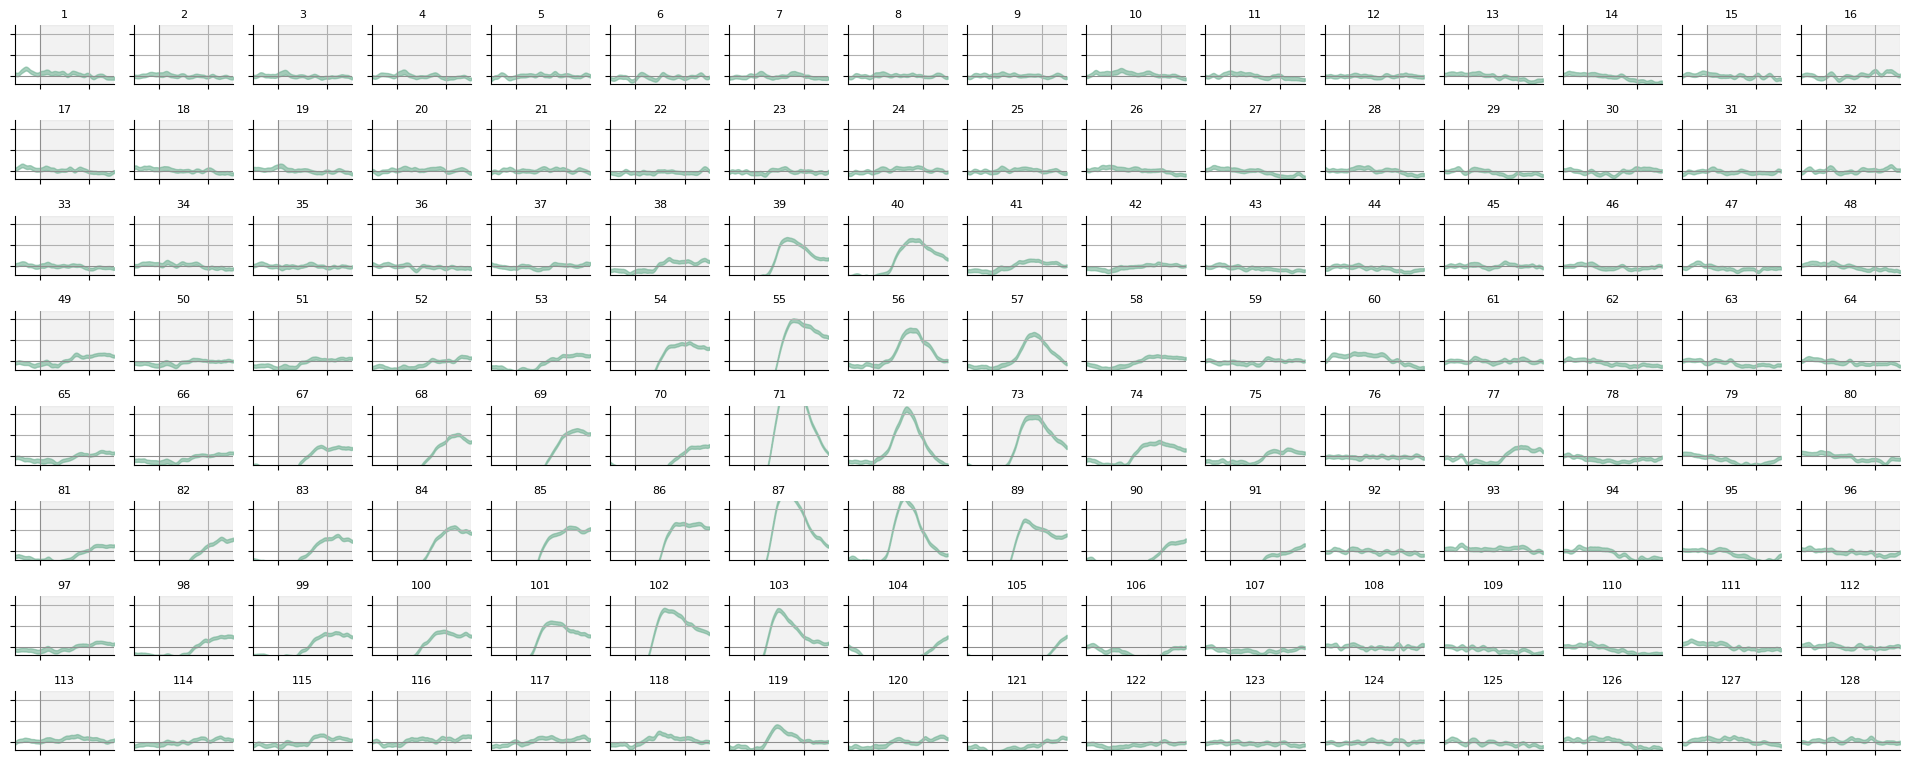

0

In [14]:
check_list = [0]
label_name = ['', 'Tone1', 'Tone2', 'Tone3', 'Tone4']
color_list = ['#70B294', '#E1804F', '#8E8CC3', '#E563A0']  # 绿 橙 紫 粉
all_elecs = range(128)

all_elecs_ERP_figure(
    ecogReading=ecogdict_speech,
    Tfull=[200, 600],
    Trange=[0, 600],
    label_name=label_name,
    check_list=check_list,
    color_list=color_list,
    elec_range=all_elecs
)

# Get Tone resp elecs

In [15]:
Trange = [0,600]
Tthres = 40
Tfull = [200,600]
check_list = [1,2,3,4]
tone_resp_elecs, tone_resp_duration, tone_resp_kxvals, _ = anova_generate(ecogdict_tone, Tfull, Trange, Tthres, check_list)
print('')
print(tone_resp_elecs)
tone_resp_elecs = [x for x in tone_resp_elecs if x in speech_resp_elecs]
print(tone_resp_elecs)

0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|242|54
0|0|0|0|0|0|0|0|0|0|0|0|12|315|68
342|69
167|70
0|0|0|0|0|0|0|0|0|0|125|81
0|247|83
317|84
452|85
267|86
0|0|152|89
25|0|0|0|0|0|0|0|0|0|122|100
245|101
0|10|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|
[85, 69, 84, 68, 86, 83, 101, 54, 70, 89, 81, 100]
[85, 69, 84, 68, 86, 83, 101, 54, 70, 89, 81, 100]


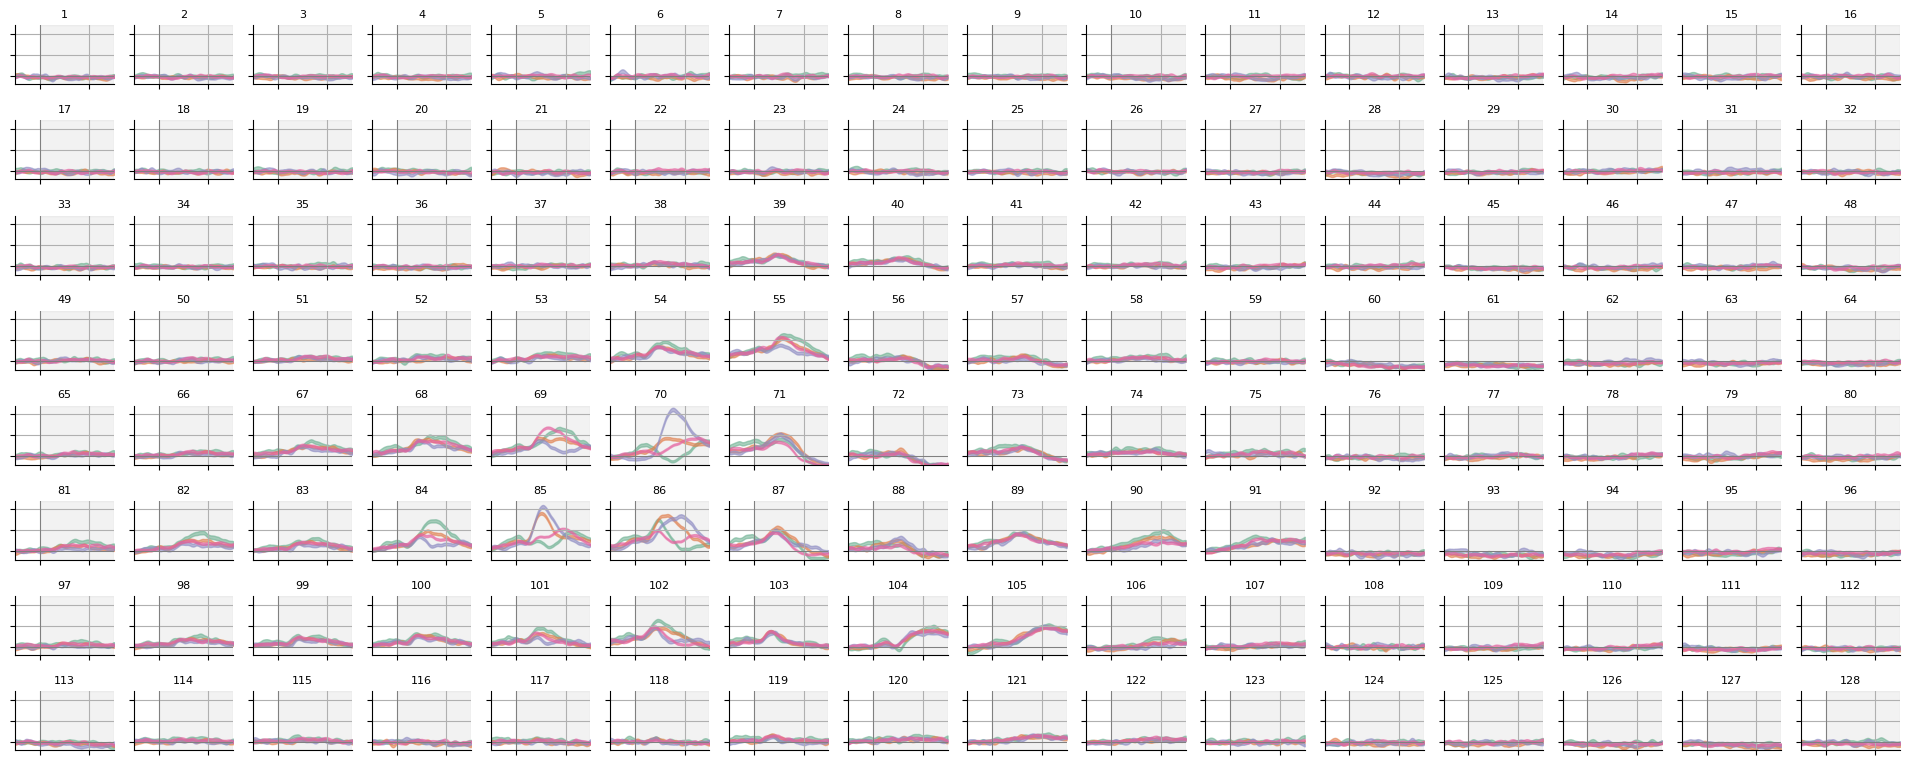

0

In [16]:
check_list = [1, 2, 3, 4]
label_name = ['', 'Tone1', 'Tone2', 'Tone3', 'Tone4']
color_list = ['#70B294', '#E1804F', '#8E8CC3', '#E563A0']  # 绿 橙 紫 粉
all_elecs = range(128)

all_elecs_ERP_figure(
    ecogReading=ecogdict_tone,
    Tfull=[200, 600],
    Trange=[0, 600],
    label_name=label_name,
    check_list=check_list,
    color_list=color_list,
    elec_range=all_elecs
)

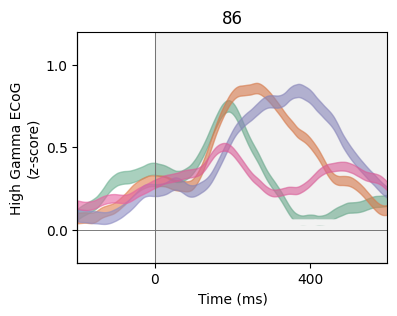

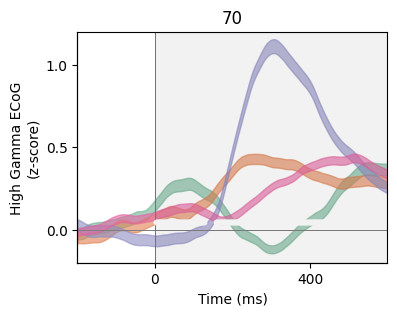

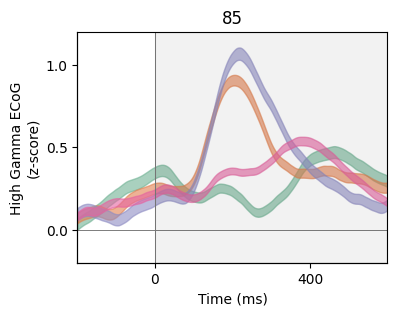

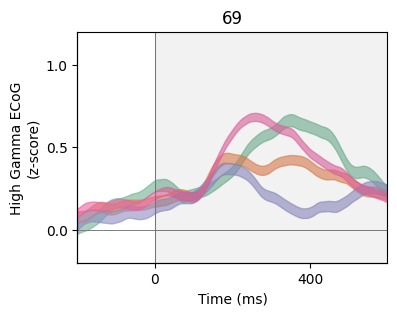

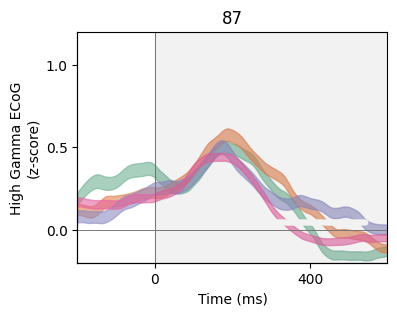

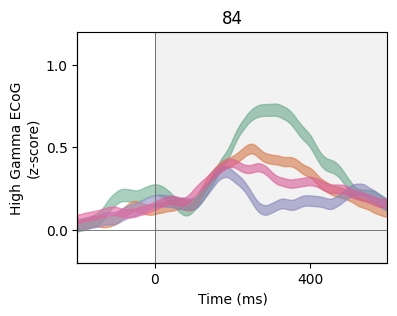

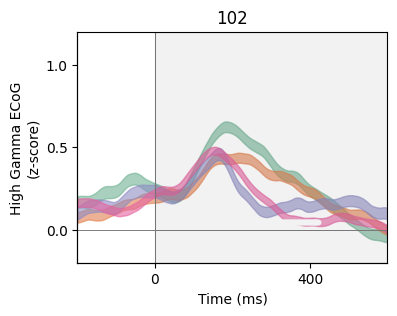

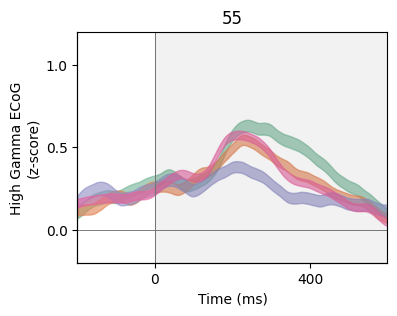

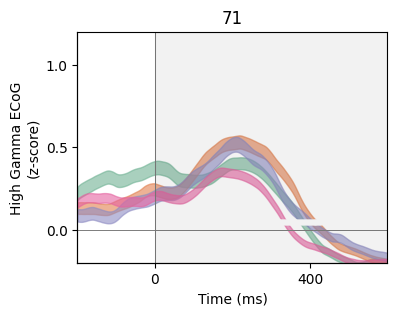

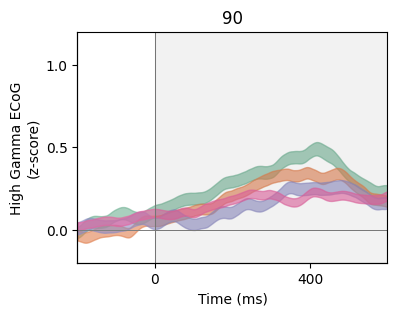

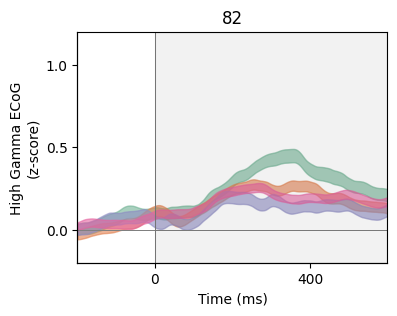

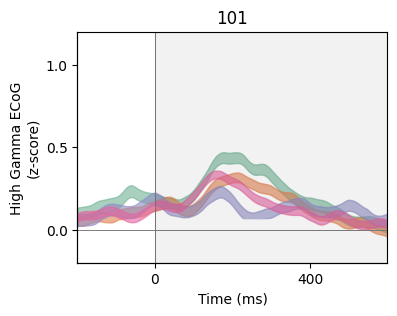

In [17]:
check_list = [1,2,3,4]
label_name = ['','Tone1', 'Tone2', 'Tone3', 'Tone4']
color_list = ['#70B294','#E1804F','#8E8CC3','#E563A0']  # 绿 橙 紫 粉

for i_pidx, pidx in enumerate(tone_resp_elecs):
    single_elecs_ERP_figure(pidx, ecogdict_tone, [200, 600], [0, 600], label_name, check_list, color_list,
                            sig_kxvals = tone_resp_kxvals[i_pidx])

# Plot on Individual Brain

In [18]:
def plot_indiv_brain2D(
        sub,
        color='k',
        name=None,
        highlight=None,
        hl_color='r',
        hl_size=5,
        sup_highlight=None,
        hl_sup_color='orange',
        hl_sup_size=7,
        default_size=3):

    img = mpimg.imread(os.path.join(os.getcwd().rstrip('/code'), f"derivatives/Brain2D/{sub}/{sub}_brain2D.png"))
    xy = scio.loadmat(os.path.join(os.getcwd().rstrip('/code'), f"derivatives/Brain2D/{sub}/{sub}_elec_pos2D.mat"))['elecmatrix'][:]

    highlight     = set(np.asarray(highlight).astype(int))     if highlight     is not None else set()
    sup_highlight = set(np.asarray(sup_highlight).astype(int)) if sup_highlight is not None else set()

    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(img)

    # ------- 逐点绘制（可改成一次性 ax.scatter，逻辑一样） ----------
    for i, (x, y) in enumerate(xy):
        if i in sup_highlight:          # ➜ tone-disc 电极
            ax.plot(x, y, 'o',
                    markersize=hl_sup_size,
                    markerfacecolor=hl_sup_color,
                    markeredgecolor='k',        # 黑色外框
                    markeredgewidth=1.2,
                    zorder=3)
        elif i in highlight:            # ➜ speech-resp 电极
            ax.plot(x, y, 'o',
                    markersize=hl_size,
                    markerfacecolor=hl_color,
                    markeredgecolor='none',     # 没外框
                    zorder=3)
        else:                           # ➜ non-resp 电极
            ax.plot(x, y, 'o',
                    markersize=default_size,
                    markerfacecolor=color,
                    markeredgecolor='none',
                    zorder=2)

    ax.axis("off")

    # ----------------------- 自定义图例 ----------------------------
    legend_elements = [
        Line2D([0], [0], marker='o', linestyle='None', color='w',
               markerfacecolor='k',            label='Non-resp.',
               markersize=6, markeredgewidth=0),
        Line2D([0], [0], marker='o', linestyle='None', color='w',
               markerfacecolor=hl_color,       label='Speech resp.',
               markersize=6, markeredgewidth=0),
        Line2D([0], [0], marker='o', linestyle='None', color='w',
               markerfacecolor=hl_sup_color,   label='Tone disc.',
               markeredgecolor='k', markeredgewidth=1.2,
               markersize=6)
    ]
    ax.legend(handles=legend_elements,
              loc='lower right', bbox_to_anchor=(1.05,-0.05), frameon=False)

    # ------------------------ 保存 / 显示 ---------------------------
    if name is not None:
        plt.savefig(path_to_save_Data+f"/{PA}/{PA}{name}.svg",
                    format="svg", dpi=300, bbox_inches='tight')
    plt.show()

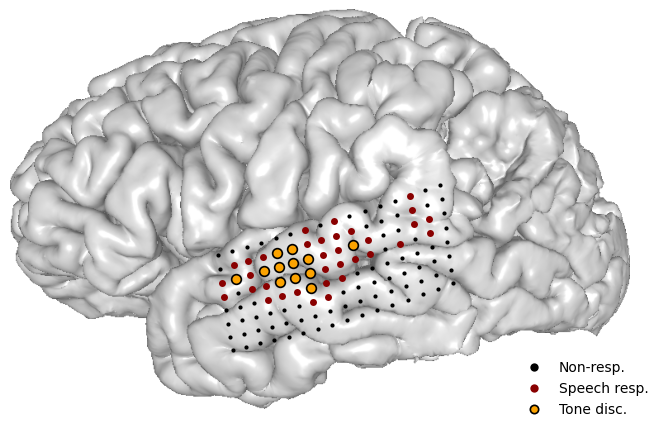

In [19]:
plot_indiv_brain2D(sub, hl_color='#890000', highlight=speech_resp_elecs, sup_highlight = tone_resp_elecs, hl_sup_color='#FCA300')